<a href="https://colab.research.google.com/github/fran-scala/Intro_to_QC_beSharp/blob/main/beSharp_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2: Simple Applications of (Variational) Quantum Algorithms 

In this second part we dive into coding Variational Quamtum Algorithms! 

<p align="center">
  <img src="./Images/QNN.jpg" alt="Variational Quantum Circuits" width="1000"/>
</p>

In [1]:
# Quantum computing libraries
import braket
import pennylane as qml
from qiskit.visualization import plot_bloch_vector # just used for visualization purposes 

# Standard python libraries
from pennylane import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

/opt/homebrew/Caskroom/miniforge/base/envs/aws/lib/python3.8/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


These definitions below are just some convenience functions for the notebook, nothing too important. 

In [2]:
def bloch_vector(state):
    """
    Calculate components in Bloch Sphere given a quantm state (a ket |psi>) 
    """
    rho = np.outer(state, np.conjugate(state))
    rx = np.trace(np.dot(rho, X)).real
    ry = np.trace(np.dot(rho, Y)).real
    rz = np.trace(np.dot(rho, Z)).real
    return rx, ry, rz

def plot_state(states, ax = None):
    """
    Plot single qubit quantum states on the bloch sphere.
    """
    if ax == None:
        fig = plt.figure(figsize=(9.6, 6))
        ax = plt.subplot(projection='3d')

    plot_bloch_vector([0, 0, 0], ax=ax)

    if states.ndim == 1:
        states = np.expand_dims(states, 0)

    cmap = cm.get_cmap('viridis', len(states))

    for i, state in enumerate(states):
        x, y, z = bloch_vector(state)
        ax.plot(y, -x, z, marker='o', color=cmap(i), markersize=10, alpha=1.)

    return ax

I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])


## 0. Rotating a qubit with a variational quantum circuit 
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _or How to make a qubit dance_

The goal of this section is to familiarize with variational operations on quantum systems using `pennylane`, a quantum computing library designed for variational quantum algorithms, which is now also integrated with Amazon's `braket`. More informations here: 
- pennylane : https://pennylane.ai/
- pennylane-braket plugin: https://amazon-braket-pennylane-plugin-python.readthedocs.io/en/latest/
- braket-pennylane examples: https://github.com/aws/amazon-braket-examples/tree/main/examples/pennylane 
 

##### Single qubit rotations


<p align="center">
  <img src="./Images/MovingQubits.jpg" alt="Energy levels" width="1000"/>
</p>

In addition to fixed single qubits operations seen before, one can also define more general operations, like rotations around the Pauli axes, as shown in the figure above, defined as

$$ 
R_x(\phi) = e^{-i\phi X/2} = \begin{bmatrix}
                                    \cos(\phi/2) & -i\sin(\phi/2) \\
                                    -i\sin(\phi/2) & \cos(\phi/2)
                                    \end{bmatrix}
$$

$$
R_y(\phi) = e^{-i\phi Y/2} = \begin{bmatrix}
                                    \cos(\phi/2) & -\sin(\phi/2) \\
                                    \sin(\phi/2) & \cos(\phi/2)
                                    \end{bmatrix}
$$

$$
R_z(\phi) = e^{-i\phi Z/2} = \begin{bmatrix}
                                    e^{-i\phi/2} & 0 \\
                                    0 & e^{i\phi/2}
                                    \end{bmatrix}
$$

#### Pennylane in action

In [3]:
? qml.RX

Init signature:  qml.RX(*params, wires=None, do_queue=True, id=None)
Docstring:     
RX(phi, wires)
The single qubit X rotation

.. math:: R_x(\phi) = e^{-i\phi\sigma_x/2} = \begin{bmatrix}
            \cos(\phi/2) & -i\sin(\phi/2) \\
            -i\sin(\phi/2) & \cos(\phi/2)
        \end{bmatrix}.

**Details:**

* Number of wires: 1
* Number of parameters: 1
* Gradient recipe: :math:`\frac{d}{d\phi}f(R_x(\phi)) = \frac{1}{2}\left[f(R_x(\phi+\pi/2)) - f(R_x(\phi-\pi/2))\right]`
  where :math:`f` is an expectation value depending on :math:`R_x(\phi)`.

Args:
    phi (float): rotation angle :math:`\phi`
    wires (Sequence[int] or int): the wire the operation acts on
File:           /opt/homebrew/Caskroom/miniforge/base/envs/aws/lib/python3.8/site-packages/pennylane/ops/qubit/parametric_ops.py
Type:           ABCMeta
Subclasses:     


Let's now see the action of these operations on a qubit! We'll use `pennylane`'s builtin functions and definitions to do that! 

First, we tell `pennylane` to create a `device` to simulate a quantum system made of 1 qubit (`wires = 1`): 

In [4]:
dev = qml.device("default.qubit", wires=1)

And then define some quantum circuits

Rx rotation with θ = 1.5707963267948966


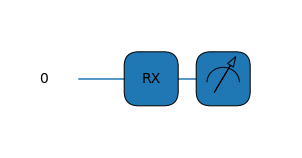

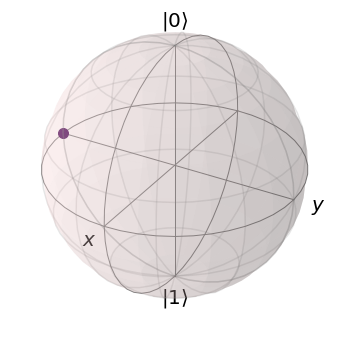

In [5]:
@qml.qnode(dev)
def circuitRX(theta):
    qml.RX(theta, wires=0)
    return qml.state()

# Choose a rotation angle
theta = np.pi/2

# Plot quantum circuit
qml.draw_mpl(circuitRX)(0.)

# Action in the bloch sphere representation
state = circuitRX(theta).numpy()
plot_state(state)

print(f"Rx rotation with θ = {theta}")

Let's check with multiple angles!

θ =  [0.      0.34907 0.69813 1.0472  1.39626 1.74533 2.0944  2.44346 2.79253
 3.14159]


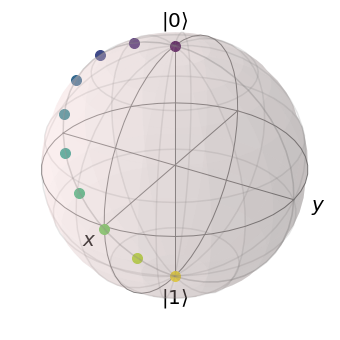

In [6]:
# Define a list of roatation angles
angles = np.linspace(0, np.pi, 10)

# Generate the quantum states, one for each angle in the list above
states = np.array([circuitRX(theta).numpy() for theta in angles])

# Plot the state on the bloch sphere!
plot_state(states)
print("θ = ", np.round(angles, 5))


Same holds with rotation around other axis Y and Z, accessed by `qml.RY` and `qml.RZ`:

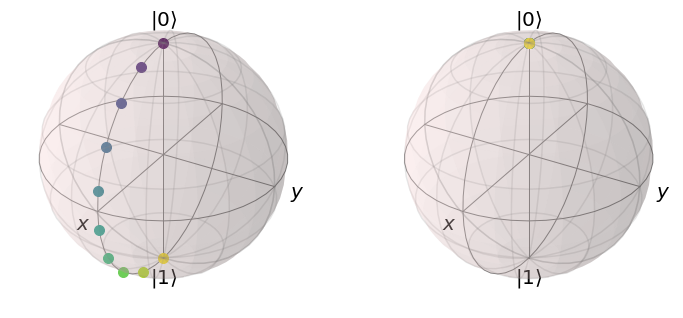

In [7]:
@qml.qnode(dev)
def circuitRY(theta):
    qml.RY(theta, wires=0)
    return qml.state()

@qml.qnode(dev)
def circuitRZ(theta):
    #qml.Hadamard(wires=0)
    qml.RZ(theta, wires=0)
    return qml.state()


fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

states = np.array([circuitRY(theta).numpy() for theta in angles])
plot_state(states, ax = ax1)

states = np.array([circuitRZ(theta).numpy() for theta in angles])
plot_state(states, ax = ax2);

#### Optimization: a complete example
Let's now build a complete example: automatically move the qubit from a starting excited state to the low energy state $|0\rangle$. The "energy" of quantum system is encoded in a matrix called _Hamiltonian_, denoted with $H$. In our case, we consider an Hamiltonian $H=-Z$, where $Z$ is the Pauli matrix:
$$
H = -Z = -\begin{bmatrix}1 & 0 \\ 0 & -1 \end{bmatrix}\,,\quad |0\rangle = \begin{bmatrix}1 \\ 0 \end{bmatrix}\,,\quad |1\rangle = \begin{bmatrix}0 \\ 1 \end{bmatrix}
$$
The energies of the single qubit _ground state_ $|0\rangle$ and the excited state $|1\rangle$ are then
$$
\text{Energy of state}\,\, |0\rangle = E_{0} = \langle 0 | H | 0 \rangle = -1
$$

$$
\text{Energy of state}\,\, |1\rangle = E_{1} = \langle 1 | H | 1 \rangle = 1
$$

We will now find a way to minimize the energy of a qubit automatically by gradient descent!  

First, define a general circuit that uses rotations `RX` and `RY` sequentially:

θ = [0.05696428 0.38638256]
Energy(θ) = -0.9247758670920672


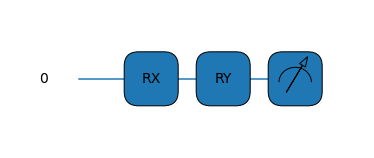

In [8]:
@qml.qnode(dev)
def energy_circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.expval(-1.*qml.PauliZ(0)) # <--- This is like an energy term, something that we want to minimize

@qml.qnode(dev)
def state_circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.state()

qml.draw_mpl(energy_circuit)([0,0,0]);

# Let's first generate three random initial parameters
thetas = np.random.rand(2)
e = energy_circuit(thetas)

print(f"θ = {thetas}")
print(f"Energy(θ) = {e}")

With this circuit, the energy function that we are trying to minimize is 

$$
|\psi\rangle = R_x(\theta)R_y(\phi)|0\rangle \implies \text{Energy of}\, |\psi\rangle\, \text{is}:\quad E_{|\psi\rangle}(\theta,\phi) :\,=\langle \psi | H | \psi \rangle = -\cos(\theta)\cos(\phi)
$$

Define an _optimization method_, in this case we use plain Gradient Descent:

In [9]:
opt = qml.GradientDescentOptimizer(stepsize=0.2)

And now we train!

In [10]:
def training_circuit(cost_function, params, **kwargs):
    """
    Optimize a cost function given some initial parameters
    """

    # Store the values of the cost function
    energy = [cost_function(params, **kwargs)]

    # Store the parameters of the circuit (the rotation angles)
    angle = [params]

    # Set some stopping criterion for the optimization
    max_iterations = 100
    conv_tol = 1e-08

    # Optimization
    for n in range(max_iterations):
        # Perform a gradient descent step and obtain new parameters in the circuit
        params, prev_energy = opt.step_and_cost(cost_function, params, **kwargs)

        # Save new energy and new parameters 
        energy.append(cost_function(params, **kwargs))
        angle.append(params)

        # Check if reached convergence
        conv = np.abs(energy[-1] - prev_energy) 

        # Print intermediate values
        if n % 2 == 0:
            print(f"Step = {n},  Energy = {energy[-1]:.8f}")

        # Break if convergence tolerance is reached
        if conv <= conv_tol:
            print("Convergence reached.")
            break

    print(f"\nFinal value of the ground-state energy = {energy[-1]:.8f}")
    print(f"Optimal value of the circuit parameter = {np.round(angle[-1], 8)}")

    return energy, np.array(angle).numpy()

initial_parameters = np.array([.23, 2.4])
energy_history, params_history = training_circuit(energy_circuit, initial_parameters)


Step = 0,  Energy = 0.62023830
Step = 2,  Energy = 0.35700455
Step = 4,  Energy = 0.02584254
Step = 6,  Energy = -0.31528179
Step = 8,  Energy = -0.60326532
Step = 10,  Energy = -0.79956428
Step = 12,  Energy = -0.90852057
Step = 14,  Energy = -0.96061733
Step = 16,  Energy = -0.98351827
Step = 18,  Energy = -0.99318799
Step = 20,  Energy = -0.99719939
Step = 22,  Energy = -0.99885111
Step = 24,  Energy = -0.99952912
Step = 26,  Energy = -0.99980708
Step = 28,  Energy = -0.99992097
Step = 30,  Energy = -0.99996763
Step = 32,  Energy = -0.99998674
Step = 34,  Energy = -0.99999457
Step = 36,  Energy = -0.99999778
Step = 38,  Energy = -0.99999909
Step = 40,  Energy = -0.99999963
Step = 42,  Energy = -0.99999985
Step = 44,  Energy = -0.99999994
Step = 46,  Energy = -0.99999997
Convergence reached.

Final value of the ground-state energy = -0.99999998
Optimal value of the circuit parameter = [6.6960e-05 1.6836e-04]


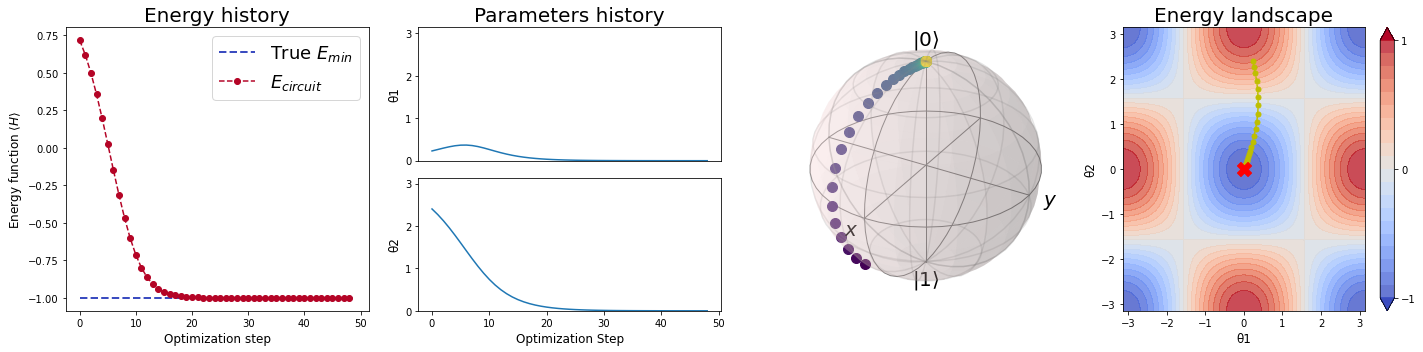

In [11]:
fig = plt.figure(figsize=(20, 5))

ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=1, rowspan=2)
ax2 = plt.subplot2grid((2, 4), (0, 1))
ax3 = plt.subplot2grid((2, 4), (1, 1))
ax4 = plt.subplot2grid((2, 4), (0, 2), projection = '3d', rowspan=2)
ax5 = plt.subplot2grid((2, 4), (0, 3), rowspan=2)

ax1.set_title("Energy history", fontsize=20)
ax1.set_xlabel("Optimization step", fontsize=12)
ax1.set_ylabel(r"Energy function $\langle H \rangle$", fontsize=12)
ax1.hlines(-1, 0, len(energy_history), lw=2, ls='--', color=cm.coolwarm(0), label="True $E_{min}$")
ax1.plot(energy_history, ls="--", marker='o', color=cm.coolwarm_r(0), label="$E_{circuit}$")
ax1.legend(fontsize = 18)

ax2.set_title("Parameters history", fontsize=20)
ax2.set_xticks([])
ax2.set_ylabel("θ1", fontsize=12)
ax2.plot(params_history[:, 0])
ax2.set_ylim(0,np.pi)

ax3.set_xlabel("Optimization Step", fontsize=12)
ax3.set_ylabel("θ2", fontsize=12)
ax3.plot(params_history[:, 1])
ax3.set_ylim(0, np.pi)

states = np.array([state_circuit(p) for p in params_history])
plot_state(states, ax=ax4)

ax5.set_title("Energy landscape", fontsize = 20)
ax5.set_xlabel("θ1", fontsize=12)
ax5.set_ylabel("θ2", fontsize=12)
x = np.linspace(-np.pi, np.pi, 100)
y = np.linspace(-np.pi, np.pi, 100)
x, y = np.meshgrid(x, y)
z = -np.cos(x)*np.cos(y)
cnt = ax5.contourf(x, y, z, 100, levels=np.arange(-1, 1.1, 0.1), cmap=cm.coolwarm, alpha=0.8, extend="both")
ax5.scatter(params_history[-1, 0], params_history[-1, 1], color='r', marker='X', s=200, zorder=2)
ax5.plot(params_history[:, 0], params_history[:, 1], ls='--', marker='.', c='y', markersize=10, zorder=1)
plt.colorbar(cnt, ticks=[-1, 0, 1])

plt.tight_layout()
plt.show()

## 1. Variational Quantum Eigensolver for Quantum Chemistry 
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _or How to find the minumum energy level of molecules_

<p align="center">
  <img src="./Images/VQE.jpg" alt="VQE" width="1000"/>
</p>

Define the energy of a system, which is encoded in an operation (a matrix) called _Hamiltonian_ H of the system.

In [12]:
coeffs = [-0.5, -1.]
operators = [qml.PauliX(0) @ qml.PauliX(1), qml.PauliZ(0) @ qml.PauliZ(1)]
H = qml.Hamiltonian(coeffs, operators)
print("Operator form of H = \n", H)

Hmat = qml.utils.sparse_hamiltonian(H).toarray()
print("\nMatrix representation of H = \n", Hmat)

Operator form of H = 
   (-1.0) [Z0 Z1]
+ (-0.5) [X0 X1]

Matrix representation of H = 
 [[-1. +0.j  0. +0.j  0. +0.j -0.5+0.j]
 [ 0. +0.j  1. +0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  1. +0.j  0. +0.j]
 [-0.5+0.j  0. +0.j  0. +0.j -1. +0.j]]


##### Creating a trial state

Energy with parameters θ = [0. 0. 0. 0.]:
E(θ) = -0.4999999999999998


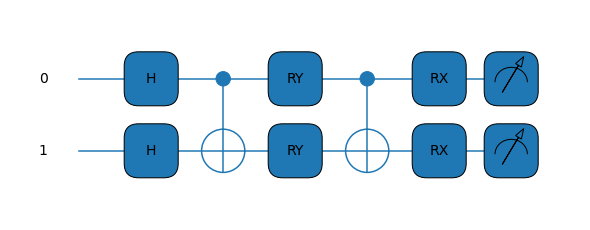

In [13]:
def circuit(parameters):
    qml.Hadamard(0)
    qml.Hadamard(1)
    qml.CNOT(wires=[0, 1])
    qml.RY(parameters[0], wires=0)
    qml.RY(parameters[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(parameters[2], wires=0)
    qml.RX(parameters[3], wires=1)

dev = qml.device('default.qubit', wires=2)
@qml.qnode(dev)
def energy_fn(parameters, hamiltonian = None):
    if hamiltonian == None:
        raise TypeError("No Hamiltionian is set! Pick an observable!")
        exit()
    circuit(parameters)
    return qml.expval(H)

qml.draw_mpl(energy_fn)([0,0,0,0], hamiltonian = H);

angles = np.array([0., 0., 0., 0.])
print(f"Energy with parameters θ = {angles}:\nE(θ) = {energy_fn(angles, hamiltonian=H)}")

In [14]:
# Define the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# Set some initial parameters
initial_parameters = np.array([0.1, 0.2, 0.22, -1.3])

# Training with the function defined above
energy_history, params_history = training_circuit(energy_fn, initial_parameters, hamiltonian=H)

# See the optimized state (the ground state)
@qml.qnode(dev)
def state_circuit2(params):
    circuit(params)
    return qml.state()

print("\nOptimized quantum state with optimal parameters:\n",
      f"|ψ> = {np.round(state_circuit2(params_history[-1]), 4).numpy()}")

Step = 0,  Energy = -0.49296331
Step = 2,  Energy = -0.60404679
Step = 4,  Energy = -0.94992101
Step = 6,  Energy = -1.38509792
Step = 8,  Energy = -1.48515606
Step = 10,  Energy = -1.49806148
Step = 12,  Energy = -1.49974840
Step = 14,  Energy = -1.49996738
Step = 16,  Energy = -1.49999577
Step = 18,  Energy = -1.49999945
Step = 20,  Energy = -1.49999993
Step = 22,  Energy = -1.49999999
Convergence reached.

Final value of the ground-state energy = -1.50000000
Optimal value of the circuit parameter = [ 3.49000000e-06 -1.57071498e+00  7.59897660e-01 -7.59897660e-01]

Optimized quantum state with optimal parameters:
 |ψ> = [0.7071-0.j 0.    -0.j 0.    +0.j 0.7071+0.j]


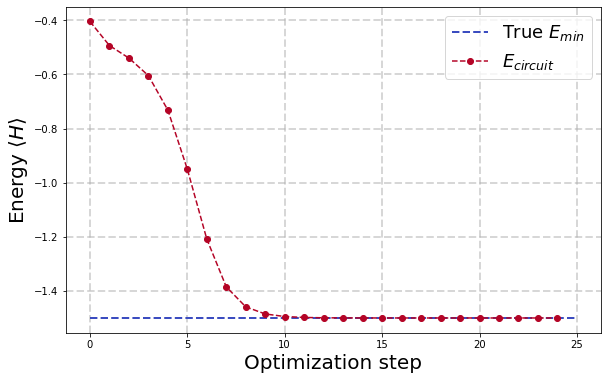

In [15]:
fig = plt.figure(figsize = (9.6, 6))

plt.ylabel(r"Energy $\langle H \rangle$", fontsize=20)
plt.xlabel("Optimization step", fontsize=20)
plt.grid(alpha=0.5, lw=2, ls='--')

# Exact minimum energy computed by classical matrix computations (lowest eigenvalue of the Hamiltionian)
true_value = np.min(np.linalg.eigvals(Hmat).numpy().real)
plt.hlines(true_value, 0, len(energy_history), lw = 2, ls = '--', color = cm.coolwarm(0), label="True $E_{min}$")

# Minimization via quantum circuit
plt.plot(energy_history, ls = '--', marker = 'o', c = cm.coolwarm_r(0), label = "$E_{circuit}$")

plt.legend(fontsize = 18)
plt.show()

## 2. Variational Quantum Circuits for Machine Learning
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; _How to pretend a quantum computer is a neural network_

In this part we are going to use a quantum circuit to classify the very famous Iris dataset, usual toy benchmark for machine learning models.

(<Figure size 576x360 with 1 Axes>, <Axes:>)

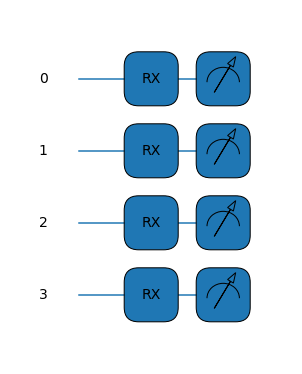

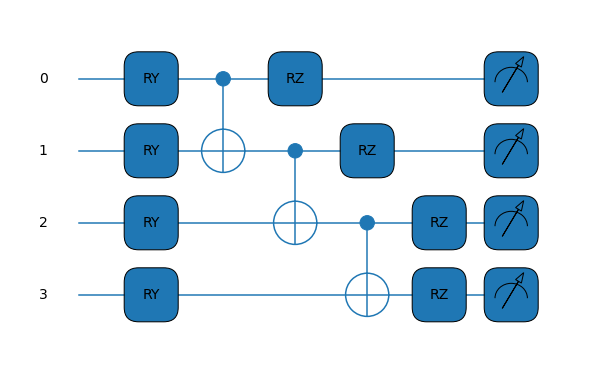

In [16]:
device = qml.device("default.qubit", wires=4)

def data_circuit(x):
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.RX(x[2], wires=2)
    qml.RX(x[3], wires=3)

def param_circuit(params):
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RY(params[2], wires=2)
    qml.RY(params[3], wires=3)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.RZ(params[4], wires=0)
    qml.RZ(params[5], wires=1)
    qml.RZ(params[6], wires=2)
    qml.RZ(params[7], wires=3)

@qml.qnode(device)
def print_circuit(circuit, parameters, **kwargs):
    circuit(parameters, **kwargs)
    return qml.state()

qml.draw_mpl(print_circuit)(data_circuit, [0]*4)
qml.draw_mpl(print_circuit)(param_circuit, [0]*8)


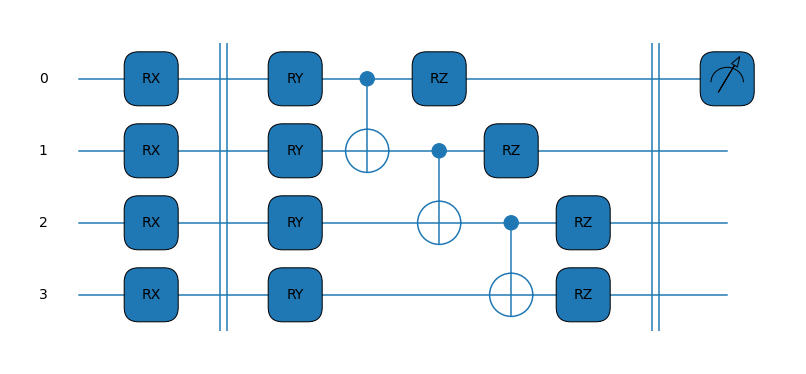

In [17]:
@qml.qnode(device)
def qnn(weights: np.ndarray, inputs = None):
    # Infer number of layers from shape of the weights matrix
    if weights.ndim == 1:
        num_layers = 1
    num_layers = weights.shape[0]

    for i in range(num_layers):
        data_circuit(inputs)
        qml.Barrier(wires=[0,1,2,3], only_visual=True)
        param_circuit(weights[i])
        qml.Barrier(wires=[0, 1, 2, 3], only_visual=True)
    return qml.expval(qml.PauliZ(0))

num_layers = 1
w = np.array([[0]*8]*num_layers)
x = np.array([0]*4)
qml.draw_mpl(qnn)(w, inputs = x);

In [18]:
def accuracy(labels, predictions, treshold = 0.9):
    acc = np.sum(np.abs(labels - predictions) < treshold)
    return acc / len(labels)

def cost(weights, bias, features = None, labels = None):
    predictions = np.array([qnn(weights, inputs = x) + bias for x in features])
    loss = np.sum((labels - predictions)**2) / len(labels)
    return loss

#### Download the dataset from Xanadu's github page

Code to download the data (a `.txt` file) and save it loally on your machine:
```
import requests
url = "https://raw.githubusercontent.com/XanaduAI/qml/master/demonstrations/variational_classifier/data/iris_classes1and2_scaled.txt"
r = requests.get(url, allow_redirects=True)
open('iris.txt', 'wb').write(r.content)
```

In [19]:
iris_dataset = np.loadtxt("iris.txt")
X, Y = iris_dataset[:, 0: 4], iris_dataset[:, -1]
print(f"First sample: {X[0]}, Label = {int(Y[0])}")

# Normalize data
Xnorm = 1. * np.pi * np.array([x / np.linalg.norm(x, requires_grad=False) for x in X], requires_grad=False)
print("Processed sample:", Xnorm[0])

First sample: [0.4  0.75 0.2  0.05], Label = -1
Processed sample: [1.43674319 2.69389348 0.71837159 0.1795929 ]


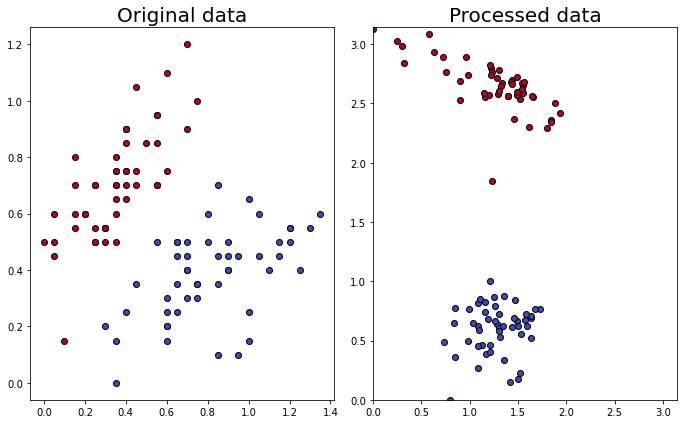

In [20]:
feature1 = 0
feature2 = 1

b = cm.coolwarm(0)
r = cm.coolwarm_r(0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9.6,6))
ax1.scatter(X[:, feature1][Y == 1], X[:, feature2][Y == 1], color=b, marker="o", edgecolors="k")
ax1.scatter(X[:, feature1][Y == -1], X[:, feature2][Y == -1], color=r, marker="o", edgecolors="k")
ax1.set_title("Original data", fontsize = 20)

ax2.scatter(Xnorm[:, feature1][Y == 1], Xnorm[:, feature2][Y == 1], color=b, marker="o", edgecolors="k")
ax2.scatter(Xnorm[:, feature1][Y == -1], Xnorm[:, feature2][Y == -1], color=r, marker="o", edgecolors="k")
ax2.set_title("Processed data", fontsize = 20)
ax2.set_xlim(0, np.pi)
ax2.set_ylim(0, np.pi)

plt.tight_layout()

##### Create training and validation dataset

In [21]:
seed = 42
np.random.seed(seed)

num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))

# Training set
X_train = Xnorm[index[:num_train]]
Y_train = Y[index[:num_train]]

# Validation set
X_val = Xnorm[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X0_train = X[index[:num_train]]
X0_val = X[index[num_train:]]

##### Training the quantum neural network!

In [22]:
# Fix hyperparams
num_qubits = 4
num_layers = 2

# Select optimizer and batch size in training
opt = qml.AdamOptimizer(0.1)
batch_size = 5

# Initialize trainable parameters
bias = np.array(0.0, requires_grad=True)
weights = 2 * np. pi * np.random.rand(num_layers, 2 * num_qubits, requires_grad=True)

loss_history = []
params_history = [[weights, bias]]

max_iterations = 35
for step in range(max_iterations):

    # Take a batch of data
    batch_index = np.random.randint(0, num_train, (batch_size,))
    X_train_batch = X_train[batch_index]
    Y_train_batch = Y_train[batch_index]

    # Perform a gradient update step
    (weights, bias), loss = opt.step_and_cost(cost, weights, bias, features=X_train_batch, labels=Y_train_batch)

    predictions_train = np.array([qnn(weights, inputs=x) + bias for x in X_train], requires_grad = False)
    acc_train = accuracy(Y_train, predictions_train).numpy()

    predictions_val = np.array([qnn(weights, inputs=x) + bias for x in X_val], requires_grad = False)
    acc_val = accuracy(Y_val, predictions_val).numpy()

    params_history.append([weights.numpy(), bias.numpy()])
    loss_history.append([loss.numpy(), acc_train, acc_val])
    
    print("Step: {:5d} | Cost: {:0.7f} | Acc. train: {:0.7f} | Acc. validation: {:0.7f} """.format(step + 1, loss, acc_train, acc_val))

# Saving intermediate results to numpy arrays for convenience
loss_history = np.array(loss_history, requires_grad=False)
params_history = np.array(params_history, dtype='object', requires_grad=False)

Step:     1 | Cost: 3.1272516 | Acc. train: 0.0533333 | Acc. validation: 0.0000000 
Step:     2 | Cost: 2.9865202 | Acc. train: 0.0533333 | Acc. validation: 0.0000000 
Step:     3 | Cost: 2.3833760 | Acc. train: 0.0800000 | Acc. validation: 0.0000000 
Step:     4 | Cost: 2.1578207 | Acc. train: 0.1066667 | Acc. validation: 0.0000000 
Step:     5 | Cost: 2.0776995 | Acc. train: 0.1333333 | Acc. validation: 0.0800000 
Step:     6 | Cost: 1.3839005 | Acc. train: 0.1866667 | Acc. validation: 0.0800000 
Step:     7 | Cost: 1.5582653 | Acc. train: 0.2933333 | Acc. validation: 0.1600000 
Step:     8 | Cost: 1.1555317 | Acc. train: 0.4133333 | Acc. validation: 0.3600000 
Step:     9 | Cost: 0.9176603 | Acc. train: 0.5600000 | Acc. validation: 0.4400000 
Step:    10 | Cost: 0.6482469 | Acc. train: 0.6800000 | Acc. validation: 0.5200000 
Step:    11 | Cost: 0.5041753 | Acc. train: 0.8533333 | Acc. validation: 0.7200000 
Step:    12 | Cost: 0.6192895 | Acc. train: 0.9733333 | Acc. validation: 0.8

/opt/homebrew/Caskroom/miniforge/base/envs/aws/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


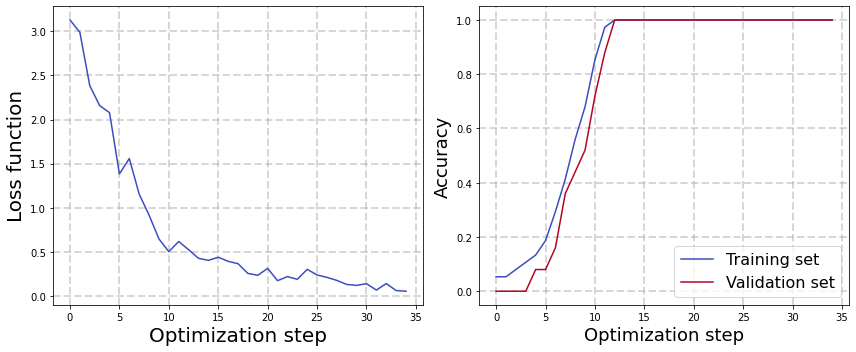

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# LOSS MINIMIAZTION PLOT
ax1.set_ylabel("Loss function", fontsize=20)
ax1.set_xlabel("Optimization step", fontsize=20)
ax1.grid(alpha=0.5, lw=2, ls='--')
ax1.plot(loss_history[:, 0], color=cm.coolwarm(0))

# ACCURAY PLOT
ax2.set_ylabel("Accuracy", fontsize=18)
ax2.set_xlabel("Optimization step", fontsize=18)
ax2.grid(alpha=0.5, lw=2, ls='--')
ax2.plot(loss_history[:, 1], color=cm.coolwarm(0), label="Training set")
ax2.plot(loss_history[:, 2], color=cm.coolwarm_r(0), label = "Validation set")
ax2.legend(fontsize = 16)

plt.tight_layout()
plt.show()

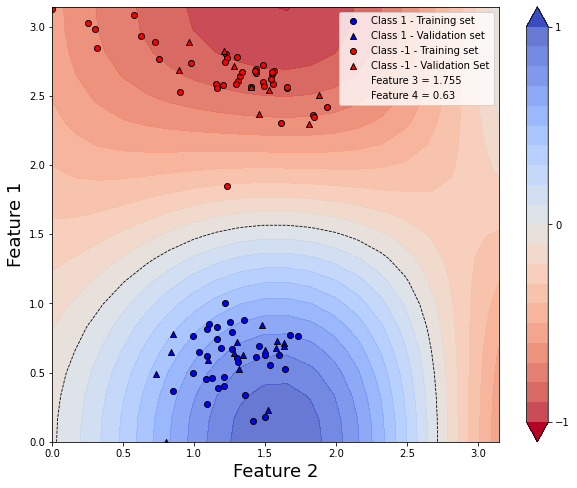

In [25]:
fig = plt.figure(figsize=(10,8))
cm2 = plt.cm.coolwarm_r

# Create grid points to show decision boundaries
f3 = np.mean(Xnorm[:, 2])
f4 = np.mean(Xnorm[:, 3])
xx, yy = np.meshgrid(np.linspace(0.0, np.pi, 20), np.linspace(0.0, np.pi, 20))
X_grid = [np.array([x, y, f3, f4]) for x, y in zip(xx.flatten(), yy.flatten())]

predictions_grid = np.array([qnn(weights, inputs=x) + bias for x in X_grid])
Z = np.reshape(predictions_grid, xx.shape)

# Plot decision regions
cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm2, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# Plot data
# Iris class 1
plt.scatter(X_train[:, 0][Y_train == 1], X_train[:, 1][Y_train == 1], c="b",marker="o", edgecolors="k", label="Class 1 - Training set")
plt.scatter(X_val[:, 0][Y_val == 1], X_val[:, 1][Y_val == 1], c="b", marker="^", edgecolors="k", label="Class 1 - Validation set")

# Iris class 2
plt.scatter(X_train[:, 0][Y_train == -1], X_train[:, 1][Y_train == -1], c="r", marker="o", edgecolors="k", label="Class -1 - Training set")
plt.scatter(X_val[:, 0][Y_val == -1], X_val[:, 1][Y_val == -1], c="r", marker="^", edgecolors="k", label="Class -1 - Validation Set")

plt.plot([], [], lw = 0, label = f"Feature 3 = {np.round(f3,3)}")
plt.plot([], [], lw = 0, label = f"Feature 4 = {np.round(f4,3)}")
plt.ylabel("Feature 1", fontsize = 18)
plt.xlabel("Feature 2", fontsize=18)

plt.legend()
plt.show()